# GAT-LSTM Load Disaggregation


In [1]:
import os, sys, yaml, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append('../src')
sys.path.append('../configs')

from utils import set_seed, visualize_actual_vs_predicted, save_model, classification
from data_preparation import load_and_process_data, create_star_edge_index
from dataset import SequenceDataset, PredictDataset
from model import GATLSTMDisaggregator, weights_init
from train import train_model, evaluate


In [2]:
with open('../configs/config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)


In [ ]:
set_seed(config.get('seed', 42))
# device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device


device(type='cpu')

In [4]:
file_path = config['file_path']
devices = config['devices']
data_cfg = config['data']
train_cfg = config['training']
model_cfg = config['model']
lookback = data_cfg['lookback']
horizon = data_cfg['horizon']
include_residual = data_cfg.get('include_residual', True)


In [5]:
raw_data = load_and_process_data(file_path, devices, rolling_window=data_cfg.get('rolling_window', 1))


# subset_ratio = 0.01
# n_rows = int(len(raw_data) * subset_ratio)
# raw_data = raw_data.iloc[:n_rows].reset_index(drop=True)

print(f'Dataset rows after preprocessing: {len(raw_data)}')

Dataset rows after preprocessing: 1048575


In [6]:
def filter_raw_data(dataframe, devices, lookback):
    """只保留至少有一台设备为 ON 的时间段，并补齐窗口起点前的 lookback-1 个时间点。"""
    device_states = []
    for dev in devices:
        values = dataframe[dev].to_numpy(dtype=float)
        state_col = f"{dev}_State"
        if state_col in dataframe.columns:
            state = (
                dataframe[state_col]
                .astype(str)
                .str.strip()
                .str.upper()
                .map({"ON": 1.0, "OFF": 0.0})
                .fillna(0.0)
                .to_numpy()
            )
        else:
            state = (values > 15.0).astype(float)  # 阈值按需调整
        device_states.append(state)

    device_states = np.stack(device_states, axis=1)
    has_device_on = device_states.sum(axis=1) > 0

    keep_idx = np.where(has_device_on)[0]
    if len(keep_idx) == 0:
        return dataframe.reset_index(drop=True)

    lookback = max(int(lookback), 1)
    expanded_idx = set()
    for idx in keep_idx:
        start = max(0, idx - (lookback - 1))
        expanded_idx.update(range(start, idx + 1))

    expanded_idx = sorted(expanded_idx)
    return dataframe.iloc[expanded_idx].reset_index(drop=True)

filtered_data = filter_raw_data(raw_data, devices, lookback)
filtered_data

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State
0,281.6,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
1,282.2,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
2,289.8,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
3,297.4,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
4,305.0,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526834,2447.2,19,0.0,OFF,0.0,OFF,1886.8,ON,14.0,OFF,154.0,ON,5.0,OFF
526835,2471.2,19,0.0,OFF,0.0,OFF,1888.0,ON,14.0,OFF,154.2,ON,5.0,OFF
526836,2482.2,19,0.0,OFF,0.0,OFF,1886.4,ON,14.0,OFF,154.0,ON,4.8,OFF
526837,2480.8,19,0.0,OFF,0.0,OFF,1886.4,ON,14.0,OFF,154.0,ON,4.8,OFF


In [9]:
subset_ratio = 0.01
n_rows = int(len(filtered_data) * subset_ratio)
raw_data = filtered_data.iloc[:n_rows].reset_index(drop=True)

In [10]:
raw_data

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State
0,281.6,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
1,282.2,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
2,289.8,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
3,297.4,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
4,305.0,7,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,0.0,OFF,2.0,OFF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,2797.6,18,0.0,OFF,0.0,OFF,1813.8,ON,0.0,OFF,156.6,ON,2.0,OFF
5264,2808.8,18,0.0,OFF,0.0,OFF,1820.2,ON,0.0,OFF,156.6,ON,2.0,OFF
5265,2802.0,18,0.0,OFF,0.0,OFF,1826.6,ON,0.0,OFF,156.6,ON,2.0,OFF
5266,2801.6,18,0.0,OFF,0.0,OFF,1828.2,ON,0.0,OFF,157.6,ON,2.0,OFF


In [11]:
split_idx = int(len(raw_data) * 0.8)
train_df = raw_data.iloc[:split_idx].reset_index(drop=True)
val_df = raw_data.iloc[max(0, split_idx - lookback):].reset_index(drop=True)
print(f'Train rows: {len(train_df)}, Validation rows: {len(val_df)}')


Train rows: 4214, Validation rows: 1078


In [12]:
train_dataset = SequenceDataset(
    train_df,
    devices=devices,
    lookback=lookback,
    horizon=horizon,
    include_residual=include_residual,
)
val_dataset = SequenceDataset(
    val_df,
    devices=devices,
    lookback=lookback,
    horizon=horizon,
    feature_scaler=train_dataset.get_feature_scaler(),
    label_scaler=train_dataset.get_label_scaler(),
    include_residual=include_residual,
)
device_pos_weight = train_dataset.get_device_pos_weight()
train_loader = DataLoader(train_dataset, batch_size=train_cfg['batch_size'], shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=train_cfg['batch_size'], shuffle=False)


In [13]:
metadata = train_dataset.get_metadata()
edge_index = create_star_edge_index(metadata.num_nodes, center=0, include_self_loops=True)
model = GATLSTMDisaggregator(
    metadata=metadata,
    public_feature_dim=train_dataset.public_feature_dim,
    horizon=horizon,
    embedding_dim=model_cfg['embedding_dim'],
    gat_hidden_dim=model_cfg['gat_hidden'],
    gat_heads=model_cfg['gat_heads'],
    gat_dropout=model_cfg['gat_dropout'],
    lstm_hidden_dim=model_cfg['lstm_hidden'],
    lstm_layers=model_cfg['lstm_layers'],
    lstm_dropout=model_cfg['lstm_dropout'],
).to(device)
model.apply(weights_init)
model


GATLSTMDisaggregator(
  (node_embedding): Embedding(8, 16)
  (gat1): GATConv(19, 64, heads=4)
  (gat2): GATConv(256, 64, heads=1)
  (gat_activation): ELU(alpha=1.0)
  (gat_dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (lstm_dropout): Dropout(p=0.1, inplace=False)
  (on_head): Linear(in_features=272, out_features=1, bias=True)
  (power_head): Linear(in_features=272, out_features=1, bias=True)
  (residual_head): Linear(in_features=272, out_features=1, bias=True)
)

In [14]:
opt_cfg = train_cfg['optimizer']
opt_type = opt_cfg['type'].lower()
if opt_type == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay', 0.0))
elif opt_type == 'adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay', 0.0))
else:
    raise NotImplementedError(f"Unsupported optimizer {opt_cfg['type']}")

scheduler = None
sched_cfg = train_cfg.get('scheduler')
if sched_cfg and sched_cfg.get('type') == 'ReduceLROnPlateau':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        factor=sched_cfg.get('factor', 0.5),
        patience=sched_cfg.get('patience', 5),
        verbose=True
    )
loss_weights = train_cfg.get('loss_weights', {'power': 3.0, 'onoff': 2.0, 'consistency': 0.2})


In [15]:
trained_model, history, val_eval = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs=train_cfg['num_epochs'],
    device=device,
    edge_index=edge_index,
    loss_weights=loss_weights,
    scheduler=scheduler,
    grad_clip=train_cfg.get('grad_clip', 1.0),
    pos_weight=device_pos_weight
)


[Epoch 001/012] train_total=1056.7099 val_total=2750.3339 val_power=764.9839 val_onoff=1.4195 val_cons=2262.7170
[Epoch 002/012] train_total=1012.8186 val_total=2716.0192 val_power=760.8174 val_onoff=1.7500 val_cons=2150.3347
[Epoch 003/012] train_total=977.6538 val_total=2683.5623 val_power=752.4111 val_onoff=0.9002 val_cons=2122.6440
[Epoch 004/012] train_total=943.1585 val_total=2651.2682 val_power=742.1601 val_onoff=0.6836 val_cons=2117.1038
[Epoch 005/012] train_total=907.9340 val_total=2617.5494 val_power=734.1243 val_onoff=0.8123 val_cons=2067.7596
[Epoch 006/012] train_total=873.2561 val_total=2583.5537 val_power=725.4098 val_onoff=0.7157 val_cons=2029.4638
[Epoch 007/012] train_total=841.4654 val_total=2553.5682 val_power=718.1308 val_onoff=0.6437 val_cons=1989.4415
[Epoch 008/012] train_total=809.9868 val_total=2523.7232 val_power=710.4938 val_onoff=0.8360 val_cons=1952.8482
[Epoch 009/012] train_total=779.5641 val_total=2492.4473 val_power=702.9874 val_onoff=0.8304 val_cons=

In [14]:
history_df = pd.DataFrame([
    {
        'epoch': entry['epoch'],
        'train_loss': entry['train']['total'],
        'val_loss': entry['val']['total'],
        'val_power': entry['val']['power'],
        'val_onoff': entry['val']['onoff'],
        'val_consistency': entry['val']['consistency'],
    }
    for entry in history
])
history_df.tail()


,epoch,train_loss,val_loss,val_power,val_onoff,val_consistency
7,8,153.752114,158.237864,139.236287,0.630562,11.928931
8,9,149.926326,153.894699,135.539721,0.641061,10.923826
9,10,146.314095,152.155285,131.621715,0.627649,13.898538
10,11,142.660717,146.861253,128.001040,0.622936,11.895213
11,12,139.306977,146.759176,127.386214,0.621521,12.562691


In [16]:
raw_eval = evaluate(
    trained_model,
    val_loader,
    device,
    edge_index,
    train_dataset.get_metadata().include_residual,
    loss_weights,
    project=False,  # 关键
    pos_weight=device_pos_weight
)

raw_preds = raw_eval['predictions']         # 这里是不投影的设备功率

In [17]:
val_samples = raw_preds.shape[0]
start_offset = lookback - 1
val_base = val_df.iloc[start_offset:start_offset + val_samples].reset_index(drop=True)
pred_cols = [f'{device}_pred' for device in devices]
pred_df = pd.DataFrame(raw_preds, columns=pred_cols)
result_df = pd.concat([val_base.reset_index(drop=True), pred_df], axis=1)
result_df.head()

,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State,Unknown_pred,WashingMachine_pred,Dishwasher_pred,Dryer_pred,Television_pred,Computer_pred
0,1491.0,16,1512.8,ON,0.0,OFF,0.0,OFF,0.0,OFF,135.2,ON,2.0,OFF,133.042130,144.496323,0.091562,0.063716,148.798965,0.911107
1,1204.4,16,1514.0,ON,0.0,OFF,0.0,OFF,0.0,OFF,133.6,ON,2.0,OFF,103.145943,144.493256,0.070507,0.026167,147.227844,0.460310
2,917.8,16,1514.0,ON,0.0,OFF,0.0,OFF,0.0,OFF,135.4,ON,2.0,OFF,65.452240,144.472900,0.033785,0.025537,145.764938,0.385627
3,912.4,16,1513.2,ON,0.0,OFF,0.0,OFF,0.0,OFF,137.0,ON,2.0,OFF,63.818375,144.475861,0.028680,0.025439,145.608246,0.269358
4,1188.4,16,1512.4,ON,0.0,OFF,0.0,OFF,0.0,OFF,138.2,ON,2.0,OFF,98.301033,144.504120,0.028542,0.025414,146.789597,0.167049


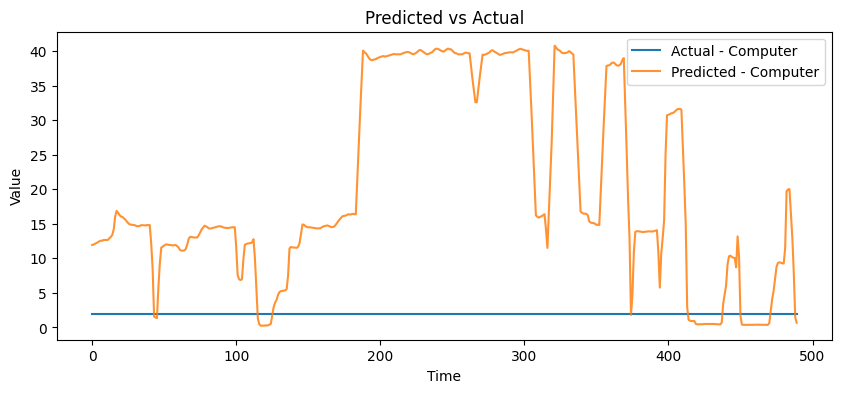

Computer: MAE=18.5036, RMSE=22.9327, R2=0.0000


In [18]:
val_preds = val_eval['predictions']
val_targets = val_eval['targets']
val_aggregates = val_eval['aggregates'].reshape(-1, 1)
visualize_actual_vs_predicted(
    [val_preds],
    [val_targets],
    [val_aggregates],
    devices,
    devices=['Computer'],
    start=10,
    end=500
)


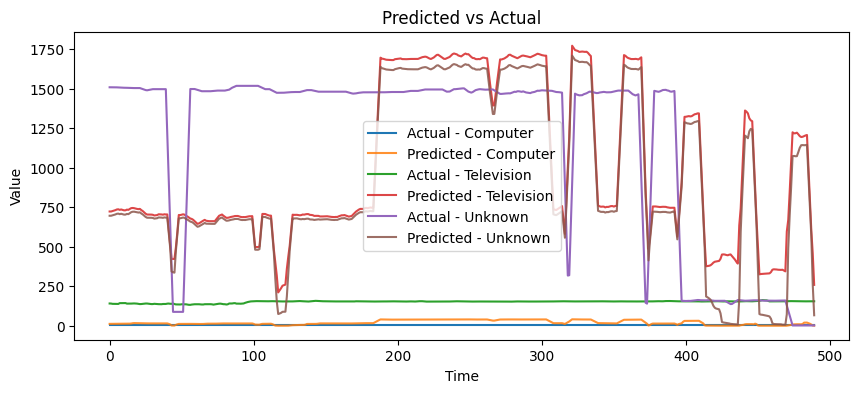

Computer: MAE=18.5036, RMSE=22.9327, R2=0.0000
Television: MAE=861.1345, RMSE=990.6352, R2=-22673.4821
Unknown: MAE=532.8015, RMSE=646.0620, R2=-0.3124


In [19]:
visualize_actual_vs_predicted(
    [val_preds],
    [val_targets],
    [val_aggregates],
    devices,
    devices=['Computer', 'Television', 'Unknown'],
    start=10,
    end=500,
)

In [18]:
val_samples = val_preds.shape[0]
start_offset = lookback - 1
val_base = val_df.iloc[start_offset:start_offset + val_samples].reset_index(drop=True)
pred_cols = [f'{device}_pred' for device in devices]
pred_df = pd.DataFrame(val_preds, columns=pred_cols)
result_df = pd.concat([val_base.reset_index(drop=True), pred_df], axis=1)
result_df.head()


,Aggregate,Hour,Unknown,Unknown_State,WashingMachine,WashingMachine_State,Dishwasher,Dishwasher_State,Dryer,Dryer_State,Television,Television_State,Computer,Computer_State,Unknown_pred,WashingMachine_pred,Dishwasher_pred,Dryer_pred,Television_pred,Computer_pred
0,369.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.810673,12.810673,12.810673,12.810673,12.810673,12.810673
1,369.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.777124,12.777122,12.777124,12.777124,12.777124,12.777124
2,369.0,15,0.0,OFF,2.0,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,12.754955,12.754955,12.754955,12.754955,12.754955,12.754955
3,563.6,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,38.197800,38.197800,38.197800,38.197800,38.197800,38.197800
4,758.2,15,0.0,OFF,1.8,OFF,0.0,OFF,0.0,OFF,136.4,ON,2.0,OFF,67.341248,67.341248,67.341240,67.341248,67.341248,67.341240


In [19]:
with torch.no_grad():
    emb = trained_model.node_embedding.weight.detach().cpu().numpy()
    for idx, name in enumerate(train_dataset.get_metadata().node_names):
        print(f"{idx:2d} {name:12s}  "
              f"norm={np.linalg.norm(emb[idx]):.4f}  "
              f"first3={emb[idx][:3]}")

 0 Total         norm=0.7283  first3=[ 0.28168163 -0.14016157  0.2080522 ]
 1 Residual      norm=0.9981  first3=[-0.34603554  0.34635964 -0.5261139 ]
 2 Unknown       norm=1.2138  first3=[0.5185937  0.40600023 0.17755902]
 3 WashingMachine  norm=0.9263  first3=[ 0.04397216 -0.5075872  -0.5884733 ]
 4 Dishwasher    norm=1.4191  first3=[-0.4391146 -0.6690053 -0.7087484]
 5 Dryer         norm=1.1527  first3=[-0.42480642 -0.57010967 -0.48622358]
 6 Television    norm=0.8209  first3=[ 0.16461018  0.36959454 -0.10886239]
 7 Computer      norm=0.9697  first3=[ 0.307871    0.13509376 -0.58012456]


In [15]:
status_df, metrics = classification(result_df, devices, return_metrics=True)
metrics


{'Unknown': {'accuracy': 0.9297618196123311,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'WashingMachine': {'accuracy': 0.9801873971818897,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Dishwasher': {'accuracy': 0.981904012588513,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Dryer': {'accuracy': 0.9998569487161147,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943},
 'Television': {'accuracy': 0.5174403356936795,
  'precision': 0.3817866769349249,
  'recall': 0.10430254576057227,
  'f1': 0.16384367512187062,
  'n': 41943},
 'Computer': {'accuracy': 0.7032877953412965,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 41943}}

In [16]:
bundle = {
    'model_state': trained_model.state_dict(),
    'feature_scaler': train_dataset.get_feature_scaler(),
    'label_scaler': train_dataset.get_label_scaler(),
    'metadata': {
        'node_names': metadata.node_names,
        'device_names': metadata.device_names,
        'include_residual': metadata.include_residual,
        'lookback': lookback,
        'horizon': horizon
    },
    'config': config
}
model_path = config['model_save_path']
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(bundle, model_path)
result_df.to_csv('prediction_results.csv', index=False)
'Artifacts saved.'


'Artifacts saved.'